In [1318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage

In [1319]:
data = pd.read_csv('dump_events.csv', sep=';')


In [1320]:
data.head()

,Номер животного,Ушная бирка животного,Пол,Номер лактации,Результат отела,Легкость отела,Дата рождения,Дней в сухостое предыдущей лактации,Дней стельности при событии,Номер группы животного,Предыдущий номер группы животного,Событие,Дни доения при событии,Дата события,Примечание события
0,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,РАСЧКОП,336,28.03.2019,КАН
1,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,ВАКЦИН,349,10.04.2019,КОГЛАВАК
2,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,ВАКЦИН,349,10.04.2019,ЛЕПТО
3,291,530073354,F,6,MA,1,30.07.2009,68,0,23,23,ПЕРЕВОД,448,08.04.2019,F001T023
4,291,530073354,F,6,MA,1,30.07.2009,68,0,23,23,ПРОДАНА,458,18.04.2019,ПРОДАНА ; Прочее ; УВЗ8


In [1321]:
data.columns = ['cow_id', 'cow_ear_num', 'sex', 'lact', 'calving_result', 'calving_score', 'date_of_birth', 'dryday_prev_period', 'day_of_preg', 'pen', 'prev_pen', 'event', 'dim', 'event_date','comment']

In [1322]:
data.head()


,cow_id,cow_ear_num,sex,lact,calving_result,calving_score,date_of_birth,dryday_prev_period,day_of_preg,pen,prev_pen,event,dim,event_date,comment
0,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,РАСЧКОП,336,28.03.2019,КАН
1,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,ВАКЦИН,349,10.04.2019,КОГЛАВАК
2,146,598621616,F,6,FA,1,29.03.2010,62,277,18,18,ВАКЦИН,349,10.04.2019,ЛЕПТО
3,291,530073354,F,6,MA,1,30.07.2009,68,0,23,23,ПЕРЕВОД,448,08.04.2019,F001T023
4,291,530073354,F,6,MA,1,30.07.2009,68,0,23,23,ПРОДАНА,458,18.04.2019,ПРОДАНА ; Прочее ; УВЗ8


In [1323]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592307 entries, 0 to 592306
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   cow_id              592307 non-null  int64 
 1   cow_ear_num         592307 non-null  object
 2   sex                 592307 non-null  object
 3   lact                592307 non-null  int64 
 4   calving_result      331357 non-null  object
 5   calving_score       592307 non-null  int64 
 6   date_of_birth       592307 non-null  object
 7   dryday_prev_period  592307 non-null  int64 
 8   day_of_preg         592307 non-null  int64 
 9   pen                 592307 non-null  int64 
 10  prev_pen            592307 non-null  int64 
 11  event               592307 non-null  object
 12  dim                 592307 non-null  int64 
 13  event_date          592307 non-null  object
 14  comment             592307 non-null  object
dtypes: int64(8), object(7)
memory usage: 67.8+ MB


In [1324]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], format='%d.%m.%Y')

In [1325]:
data['event_date'] = pd.to_datetime(data['event_date'], format='%d.%m.%Y')

In [1326]:
data['event'].unique()

array(['РАСЧКОП', 'ВАКЦИН', 'ПЕРЕВОД', 'ПРОДАНА', 'МАСТИТ', 'ЗДОРОВА',
       'ХРОМОТА', 'СУХОСТ', 'ВАКВИРУС', 'ЯЛОВАЯ', 'ОСЕМЕН', 'БОЛЕЗНЬ',
       'НЕОСЕМ', 'СТЕЛН', 'ПРОФОТ', 'ОТЕЛ', 'ПАРЕЗ', 'МЕТРИТ', 'КЕТОЗ',
       'ПОСЛЕД', 'ПАЛА', 'АБОРТ', 'ВЕС', 'СТЕЛНДО', 'НА_СХЕМУ',
       'СО_СХЕМЫ', 'SOLD', 'WEIGHT', 'METR', 'DRY', 'MOVE', 'FOOTRIM',
       'WELL', 'POT', 'ILLMISC', 'MAST', 'BRED', 'LAME', 'RP', 'FRESH',
       'OPEN', 'DNB', 'NULSCM', 'ABORT', 'ДЕФЕКТ', 'СУХ2', 'TOSCM',
       'KETOS'], dtype=object)

In [1327]:
EVENTS = {'АБОРТ' : 1,
'БОЛЕЗНЬ' : 2,
'ВАКВИРУС' : 3,
'ВАКЦИН' : 4,
'ВЕС' : 5,
'ДЕФЕКТ' : 6,
'ЗДОРОВА' : 7,
'КЕТОЗ' : 8, 
'МАСТИТ' : 9,
'МЕТРИТ' : 10,
'НА_СХЕМУ' : 11,
'НЕОСЕМ' : 12,
'ОСЕМЕН' : 13,
'ОТЕЛ' : 14, 
'ПАЛА' : 15, 
'ПАРЕЗ' : 16, 
'ПЕРЕВОД' : 17,
'ПОСЛЕД' : 18,
'ПРОДАНА' : 19,
'ПРОФОТ' : 20,
'РАСЧКОП' : 21, 
'СО_СХЕМЫ' : 22,
'СТЕЛН' : 23,
'СТЕЛНДО' : 24,
'СУХ2' : 25,
'СУХОСТ' : 26, 
'ХРОМОТА' : 27, 
'ЯЛОВАЯ' : 28,
'ABORT' : 1,
'BRED' : 13, 
'DNB' : 12,
'DRY' : 26, 
'FOOTRIM' : 21,
'FRESH' : 14,
'ILLMISC' : 2,
'KETOS' : 8,
'LAME' : 27,
'MAST' : 9, 
'METR' : 10,
'MOVE' : 17, 
'NULSCM' : 22,
'OPEN' : 28,
'POT' : 20,
'RP' : 18,
'SOLD' : 19, 
'TOSCM' : 11,
'WEIGHT' : 5,
'WELL' : 7}


In [1328]:
def digitize_event_category_col(dt):
    dt_copy = dt.copy()
    dt_copy['event'] = pd.Series(map(lambda n: EVENTS[n], list(data['event'])))
    return dt_copy


In [1329]:
data = digitize_event_category_col(data)

In [1330]:
data['days_from_birth'] = data['event_date'] - data['date_of_birth']
data['days_from_birth'] = data['days_from_birth'].dt.days.astype(int)
data['month'] = data['event_date'].dt.to_period('M')

In [1331]:
data['is_ill'] = 0
#колонка покажет, что животное более любой болезнью из списка illness_list

In [1332]:
illness_num = [1, 2, 8, 9, 10, 15, 16, 18, 19, 27]

In [1333]:
data.loc[data['event'] == 1, 'is_ill'] = data.loc[data['event']  == 1, 'is_ill'].replace(0,1)
data.loc[data['event'] == 2, 'is_ill'] = data.loc[data['event']  == 2, 'is_ill'].replace(0,1) 
data.loc[data['event'] == 8, 'is_ill'] = data.loc[data['event']  == 8, 'is_ill'].replace(0,1)
data.loc[data['event'] == 9, 'is_ill'] = data.loc[data['event']  == 9, 'is_ill'].replace(0,1)
data.loc[data['event'] == 10, 'is_ill'] = data.loc[data['event']  == 10, 'is_ill'].replace(0,1)
data.loc[data['event'] == 16, 'is_ill'] = data.loc[data['event']  == 16, 'is_ill'].replace(0,1)
data.loc[data['event'] == 15, 'is_ill'] = data.loc[data['event']  == 15, 'is_ill'].replace(0,1)
data.loc[data['event'] == 18, 'is_ill'] = data.loc[data['event']  == 18, 'is_ill'].replace(0,1)
data.loc[data['event'] == 19, 'is_ill'] = data.loc[data['event']  == 19, 'is_ill'].replace(0,1)
data.loc[data['event'] == 27, 'is_ill'] = data.loc[data['event']  == 27, 'is_ill'].replace(0,1)

# Общая информация

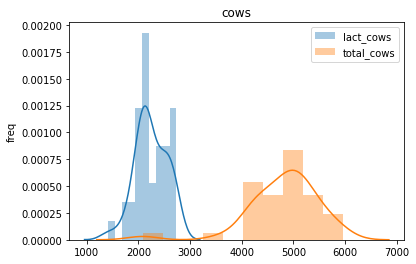

In [1334]:
sns.distplot(data.query('dim > 0 and lact > 0').pivot_table(
index = 'month',
values = 'cow_id',
aggfunc = 'nunique'), label = 'lact_cows', bins = 10)    
                 
sns.distplot(data.pivot_table(
index = 'month',
values = 'cow_id',
aggfunc = 'nunique'), label = 'total_cows', bins = 10)
plt.title('cows')
plt.ylabel('freq')
plt.legend()
plt.show()

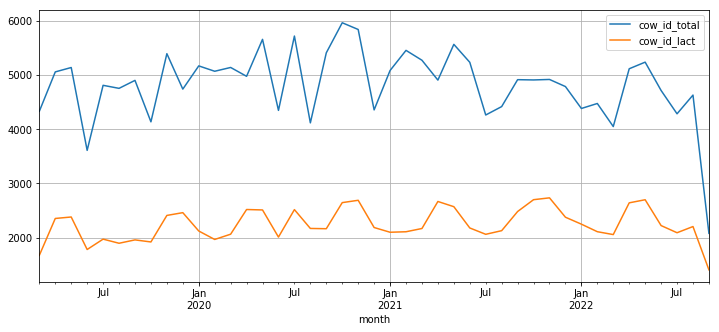

In [1335]:
data.pivot_table(
index = 'month',
values = 'cow_id',
aggfunc = 'nunique').merge(data.query('dim > 0 and lact > 0').pivot_table(
index = 'month',
values = 'cow_id',
aggfunc = 'nunique'), on = 'month', suffixes=('_total', '_lact')).fillna(0).plot(grid=True, figsize=(12, 5))


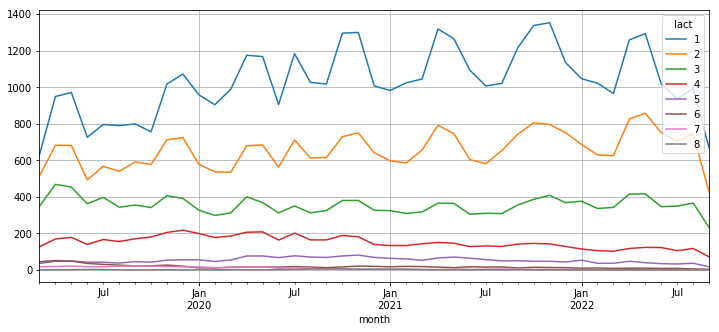

In [1336]:
data.query('lact > 0').pivot_table(
    index = "month",  
    columns = "lact",
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(12, 5)) ##структура стада без телят

# Хромота

In [1337]:
data_lame = data.query('event ==27')

In [1338]:
data_lame[['protocol','legs']] = data_lame['comment'].str.split('_', 1,expand=True)

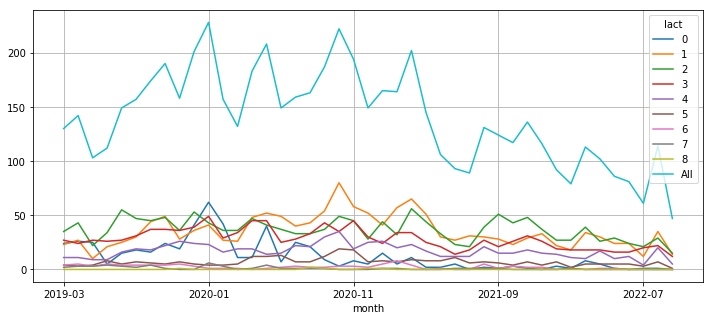

In [1339]:
data_lame.pivot_table(
index = 'month',
columns = 'lact',
values = 'cow_id',
aggfunc = 'nunique', margins = True).iloc[0:-1].fillna(0).plot(grid=True, figsize=(12, 5)) 
# общее количество хромых коров снизилось

In [1478]:
data_lame.pivot_table(
index = 'month',
columns = 'lact',
values = 'cow_id',
aggfunc = 'nunique', margins = True)

lact,0,1,2,3,4,5,6,7,8,All
month,,,,,,,,,,
2019-03,24.0,23.0,35.0,27.0,11.0,4.0,4.0,2.0,NaN,130
2019-04,26.0,27.0,43.0,24.0,11.0,3.0,5.0,3.0,NaN,142
2019-05,25.0,10.0,22.0,27.0,9.0,4.0,3.0,3.0,NaN,103
2019-06,5.0,21.0,34.0,26.0,9.0,8.0,5.0,4.0,NaN,112
2019-07,15.0,25.0,55.0,27.0,16.0,5.0,4.0,3.0,NaN,149
2019-08,18.0,30.0,47.0,31.0,19.0,7.0,4.0,2.0,NaN,157
2019-09,16.0,44.0,45.0,37.0,18.0,6.0,4.0,4.0,NaN,174
2019-10,24.0,49.0,48.0,37.0,22.0,5.0,4.0,1.0,NaN,190
2019-11,19.0,28.0,36.0,36.0,26.0,7.0,5.0,NaN,1.0,158


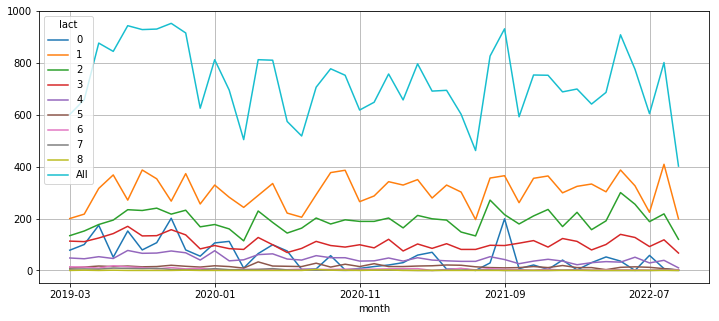

In [1340]:
data.query('event==21').pivot_table(
index = 'month',
columns = 'lact',
values = 'cow_id',
aggfunc = 'count', margins = True).iloc[0:-1].fillna(0).plot(grid=True, figsize=(12, 5)) 
# общее количество проводимой профилактики тоже снизилось

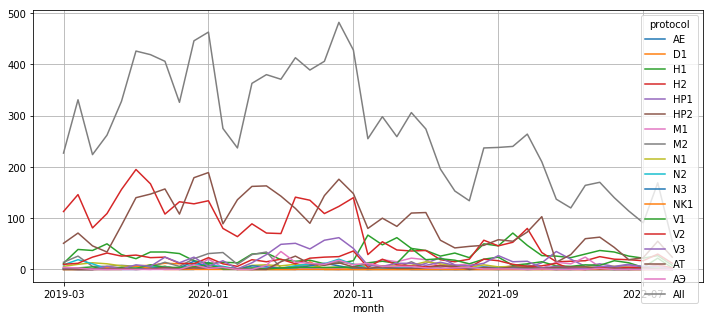

In [1341]:
data_lame.pivot_table(
index = 'month',
columns = 'protocol',
values = 'cow_id',
aggfunc = 'count', margins = True).iloc[:-1].fillna(0).plot(grid=True, figsize=(12, 5)) 

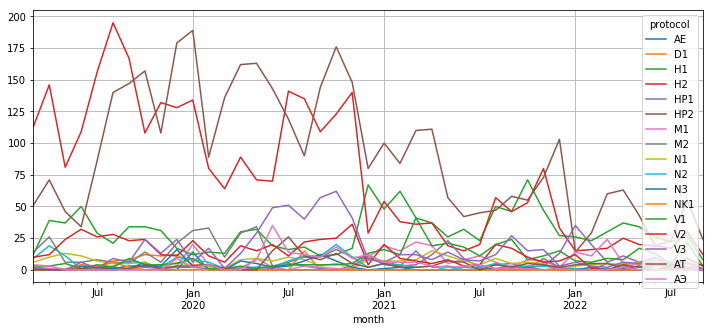

In [1342]:
data_lame.pivot_table(
index = 'month',
columns = 'protocol',
values = 'cow_id',
aggfunc = 'count').fillna(0).plot(grid=True, figsize=(12, 5)) 

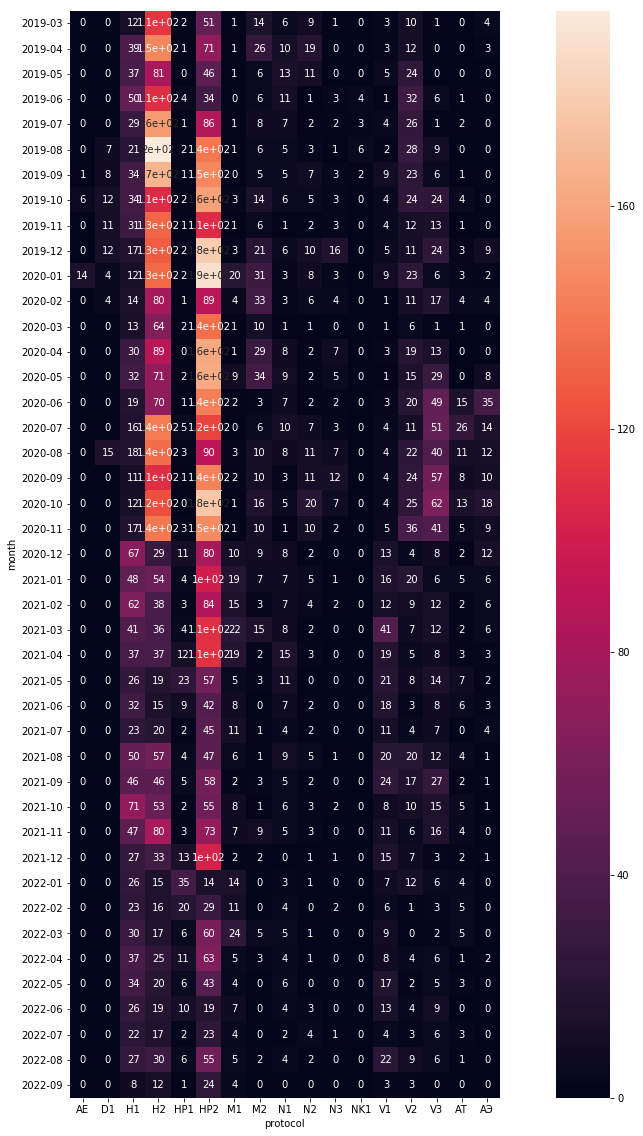

In [1343]:
plt.figure(figsize = (20,20))
sns.heatmap(data_lame.pivot_table(
index = 'month',
columns = 'protocol',
values = 'cow_id',
aggfunc = 'count').fillna(0), annot = True, square = True)

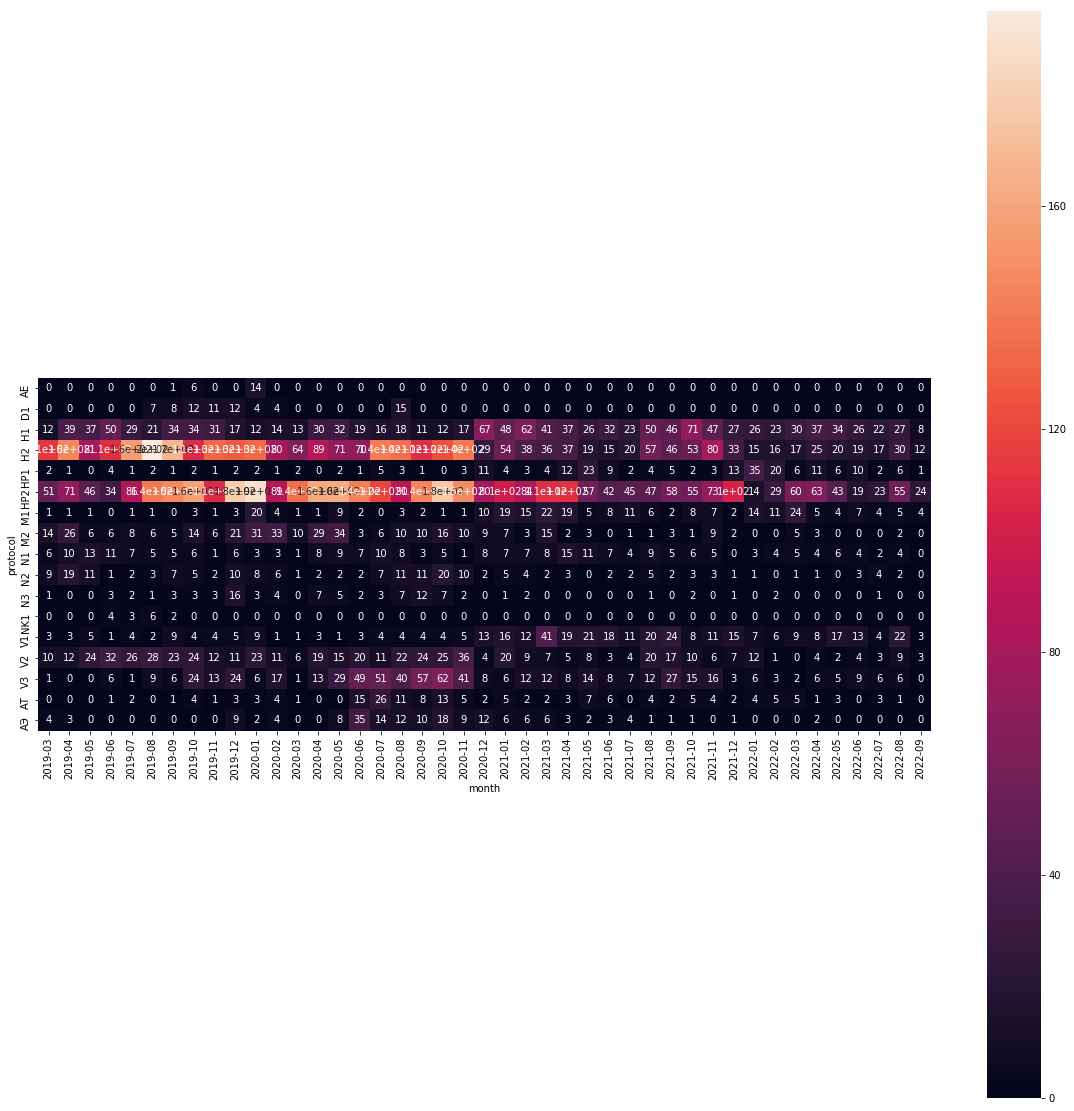

In [1479]:
plt.figure(figsize = (20,20))
sns.heatmap(data_lame.pivot_table(
index = 'protocol',
columns = 'month',
values = 'cow_id',
aggfunc = 'count').fillna(0), annot = True, square = True)

С ноября 2020 года идет снижение количества больных коров и "улегчение" состояния копыт. Уходят протоколы H2 и HP2, и увеличивается чатота использования протокола H1. В ходе лечения используют копытные ванны. Возможно, изменили раствор или процедуру контроля ph раствора в ванных и частоту смены раствора

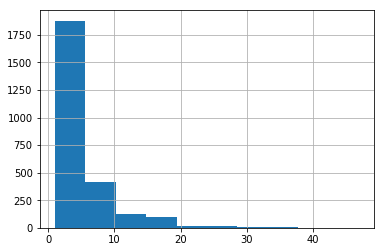

In [1344]:
data_lame['cow_id'].value_counts().hist() ## большинство коров попадают в событие lame до 15 раз за свою жизнь, но есть исключения: 
## рассмотреть вопрос экономической эффективности лечить корову более 20 раз.

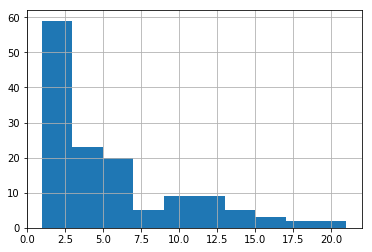

In [1345]:
data_lame.query('lact ==5')['cow_id'].value_counts().hist() ## большинство коров попадают в событие lame до 15 раз за свою жизнь, но есть исключения: 
## рассмотреть вопрос экономической эффективности лечить корову более 20 раз.

In [1346]:
data_lame['protocol'].unique()

array(['H2', 'H1', 'N1', 'HP2', 'HP1', 'M2', 'N2', 'V2', 'N3', 'АЭ', 'V1',
       'V3', 'M1', 'NK1', 'АТ', 'D1', 'AE'], dtype=object)

# Общие сведения по болезням

In [1347]:
ill_cow = data.pivot_table(
    index='month', 
    aggfunc={'is_ill':'sum', 'cow_id':'nunique'})

In [1348]:
ill_cow['percent_of_sick'] = (ill_cow['is_ill']/ill_cow['cow_id'])*100

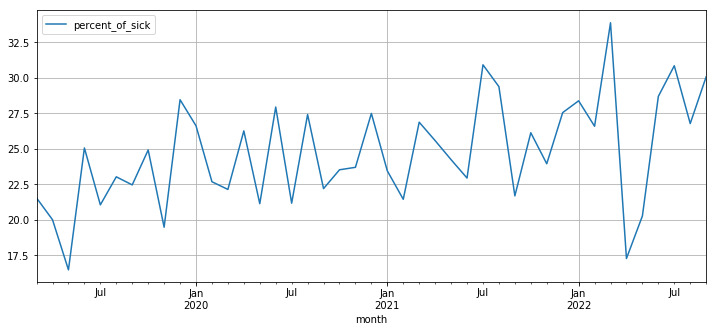

In [1349]:
ill_cow[['percent_of_sick']].fillna(0).plot(grid=True, figsize=(12, 5))

In [1350]:
ill_cow[['percent_of_sick']].median()

percent_of_sick    24.245147
dtype: float64

In [1351]:
count_of_issues = data.pivot_table(index = 'month', columns = 'lact', aggfunc ={'event':'count'})

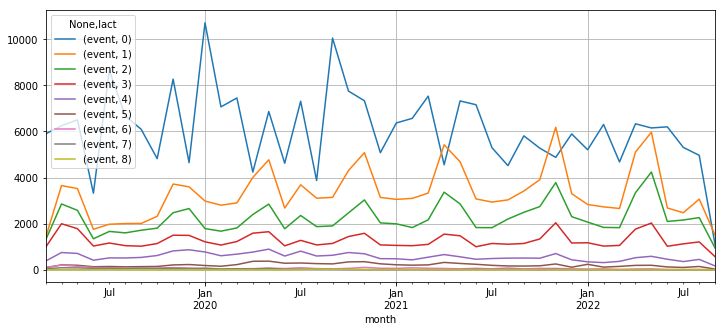

In [1352]:
count_of_issues.fillna(0).plot(grid=True, figsize=(12, 5))

Плавно снижается количество заболеваний у всех лактаций

# Маститы

In [1353]:
data_mastitis_and_health =  data.query('event == 9 or (event == 7 and comment == "МАСТИТ")').reset_index()


In [1354]:
data_mastitis_and_health.columns = ['unique_event_id', 'cow_id', 'cow_ear_num', 'sex', 'lact', 'calving_result',
       'calving_score', 'date_of_birth', 'dryday_prev_period', 'day_of_preg',
       'pen', 'prev_pen', 'event', 'dim', 'event_date', 'comment',
       'days_from_birth', 'month', 'is_ill']

In [1355]:
data_mastitis = data_mastitis_and_health.query('event == 9 ')

In [1356]:
data_mastitis[['protocol','part']] = data_mastitis['comment'].str.split('_', 1,expand=True)

In [1357]:
data_mastitis.loc[(data_mastitis['protocol']=='MB'), 'protocol'] = data_mastitis.loc[(data_mastitis['protocol']=='MB'), 'protocol'].replace('MB', 'МВ')

In [1358]:
data_mastitis['part'] = data_mastitis['part'].fillna('0')

In [1359]:

data_mastitis['part'] = data_mastitis['part'].astype('str')

In [1360]:
data_mastitis['part'] = data_mastitis['part'].replace('1_4', '1234')
data_mastitis['part'] = data_mastitis['part'].replace('1-4', '1234')
data_mastitis['part'] = data_mastitis['part'].replace('1_3', '123')
data_mastitis['part'] = data_mastitis['part'].replace('1-3', '123')
data_mastitis['part'] = data_mastitis['part'].replace('2_4', '234')
data_mastitis['part'] = data_mastitis['part'].replace('2-4', '234')

In [1361]:
data_mastitis[['FR','FL', 'BR', 'BL']] = 0

In [1362]:
data_mastitis['FL'] = data_mastitis['part'].str.contains('1', na=False, regex=True).astype(int)

In [1363]:
data_mastitis['FR'] =  data_mastitis['part'].str.contains('2', na=False, regex=True).astype(int)
data_mastitis['BL'] = data_mastitis['part'].str.contains('3', na=False, regex=True).astype(int)
data_mastitis['BR'] = data_mastitis['part'].str.contains('4', na=False, regex=True).astype(int)


In [1364]:
pivot_common = data_mastitis.pivot_table(index='month', values = 'cow_id', aggfunc={'count','nunique'})

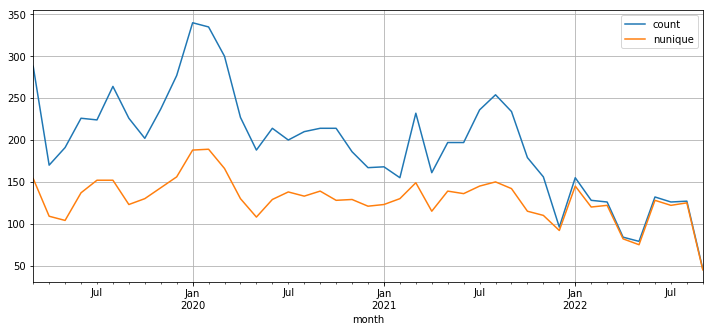

In [1365]:
data_mastitis.pivot_table(
    index='month', 
    values = 'cow_id', 
    aggfunc={'count','nunique'}).fillna(0).plot(grid=True, figsize=(12, 5)) 
## мастит кколичество случаев и кол-во больнх коров

Количество маститов снижаетс после июля 2021 года

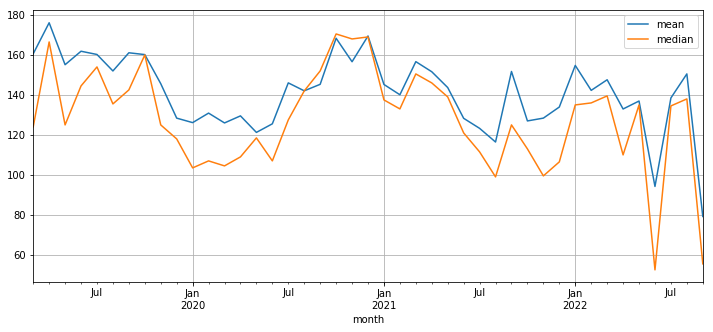

In [1366]:
data_mastitis.pivot_table(
    index='month', 
    values = 'dim', 
    aggfunc={'mean','median'}).fillna(0).plot(grid=True, figsize=(12, 5)) 
## дней в доении у больных коров в среднем и медиана

В июне 2022 года пробило маститом коров до 60 дня доения - медиана всех заболевших маститом коров ушла ниже 60 дней:
- стали больше болеть новотельные?
- перестали болеть остальные коровы?

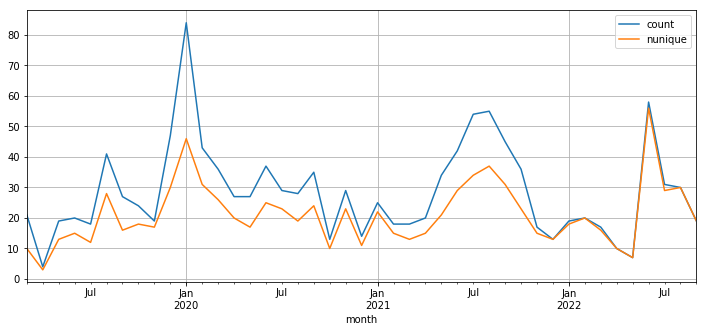

In [1367]:
data_mastitis.query("dim > 0 and dim < 30").pivot_table(
    index='month', 
    values = 'cow_id', 
    aggfunc={'count','nunique'}).fillna(0).plot(grid=True, figsize=(12, 5))

График маститов у ноотельных коров показывает снижение повторных заболеваний и уменьшение общего количества маститов с периодическими сплесками

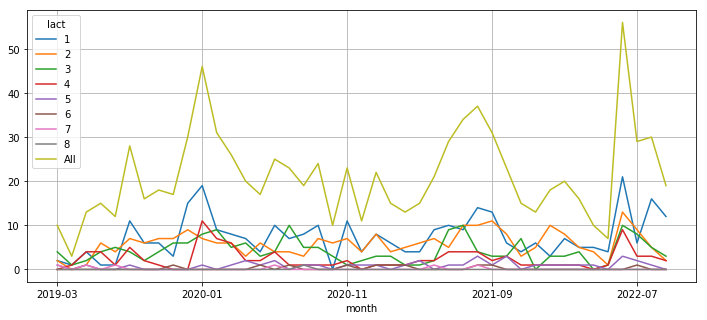

In [1368]:
data_mastitis.query("dim > 0 and dim < 30").pivot_table(
    index='month',
    columns = 'lact',
    values = 'cow_id', 
    aggfunc='nunique', margins = True).iloc[:-1].fillna(0).plot(grid=True, figsize=(12, 5))

Всплеск мастита произошел у новотельных всех лактаций в июле 2021

In [1369]:
data_mastitis.query('dim > 0 and dim < 30 and month > "2022-04-01" and month < "2022-08-01"').pivot_table(
    index='month',
    columns = 'lact',
    values = 'cow_id', 
    aggfunc='nunique', margins = True).fillna(0)

lact,1,2,3,4,5,6,All
month,,,,,,,
2022-05,4.0,1.0,1.0,1.0,0.0,0.0,7
2022-06,21.0,13.0,10.0,9.0,3.0,0.0,56
2022-07,6.0,9.0,8.0,3.0,2.0,1.0,29
All,30.0,23.0,17.0,13.0,5.0,1.0,89


В июле всплеск случаев мастита у новотельных коров 1 лактации. 
Возможные причины - содержание молодняка и глубокостельных телок.

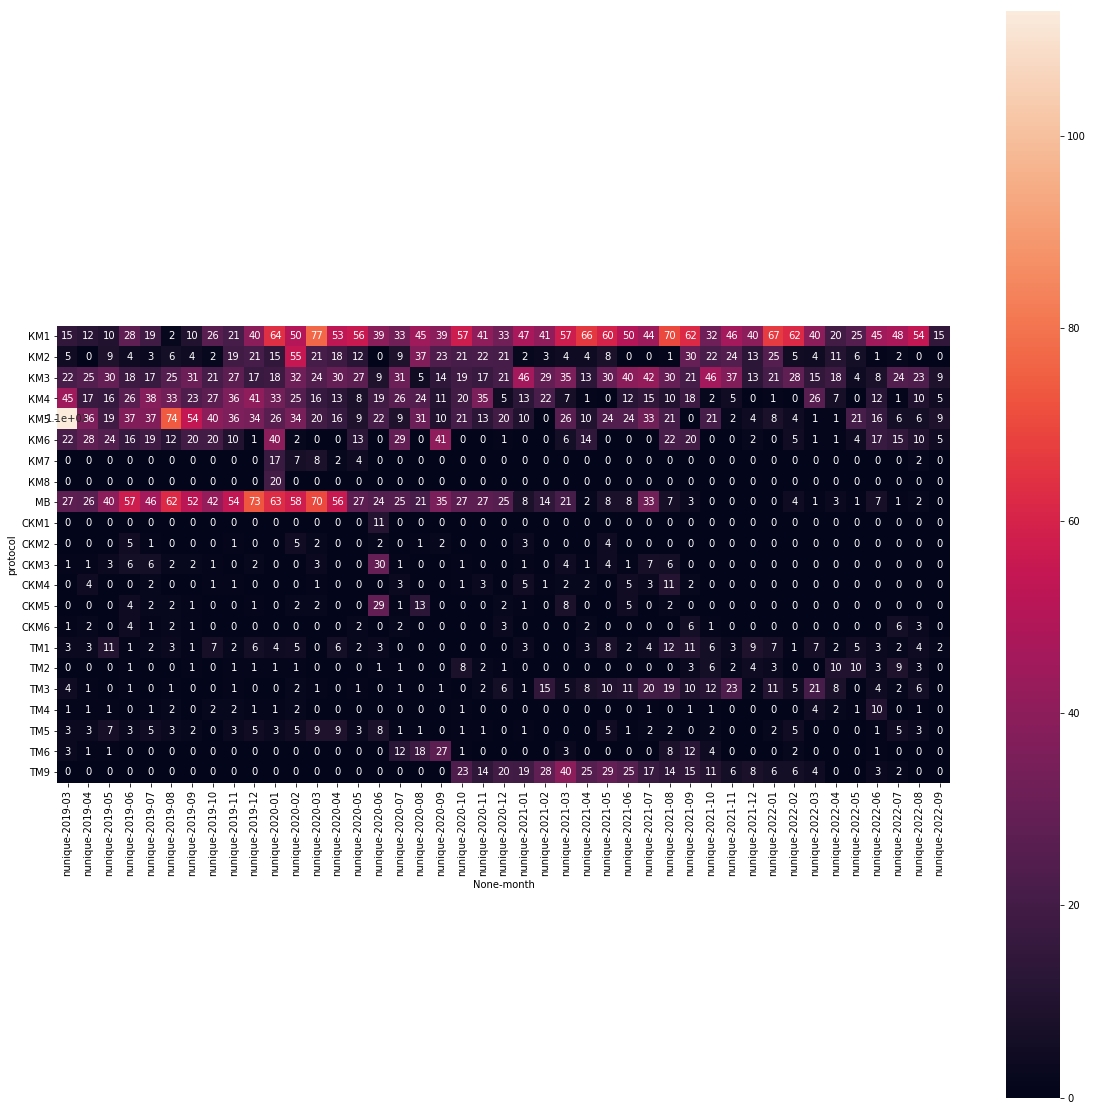

In [1476]:
plt.figure(figsize = (20,20))
sns.heatmap(data_mastitis.pivot_table(
    index='protocol', 
    columns = 'month',
    values = 'cow_id', 
    aggfunc={'nunique'}).fillna(0), annot = True, square = True)

Вопрос целесообразности перехода со 2 на 3 протокол, учитывая что это амоксициллин и пенициллин.(Опасно)
Травматические маститы - причина была в доильном зале? вакуум? или полы?

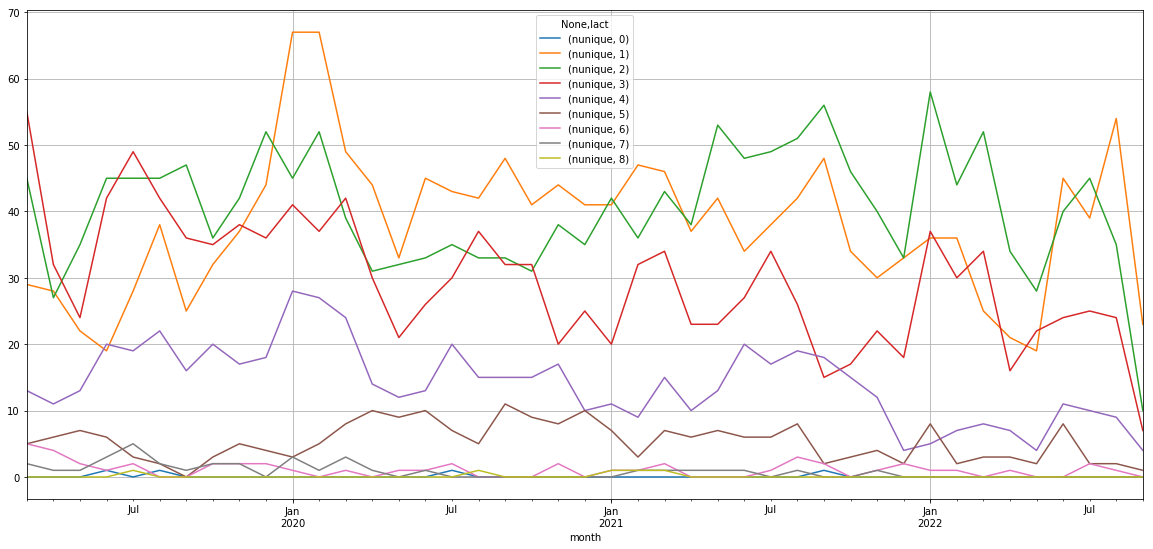

In [1371]:
data_mastitis.pivot_table(
    index='month',
    columns = 'lact',
    values = 'cow_id', 
    aggfunc={'nunique'}).fillna(0).plot(grid=True, figsize=(20, 9)) ##заболело коров по месяцам и лактациям

Рост у 1телок, у всех остальных снижается

In [1482]:
data.query('event == 4 and lact==1 and dim > 0 and dim < 30 and month > "2022-01-01"').pivot_table(
    index = "month", 
    columns = 'comment', 
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0)

comment,КОГЛАВАК,КРОВЬ,ЛЕПТО,СИБИР,ТУБЕР
month,,,,,
2022-04,0.0,5.0,0.0,3.0,36.0
2022-05,68.0,0.0,68.0,0.0,0.0


Увеличение маститов може быть связано с повышенной нагрузкой от двойной вакцинации у новотельных

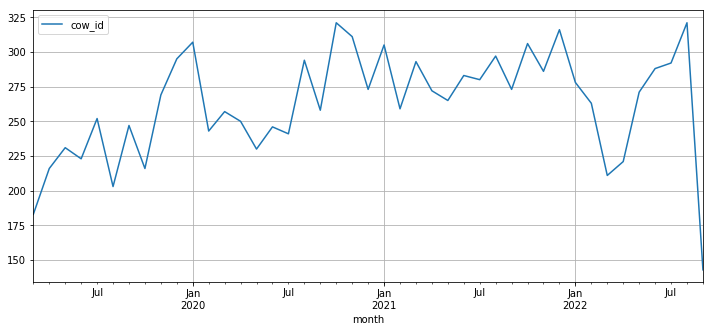

In [1374]:
data.query('lact > 0 and event ==14').pivot_table(
    index = "month",  
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(12, 5)) #отелы

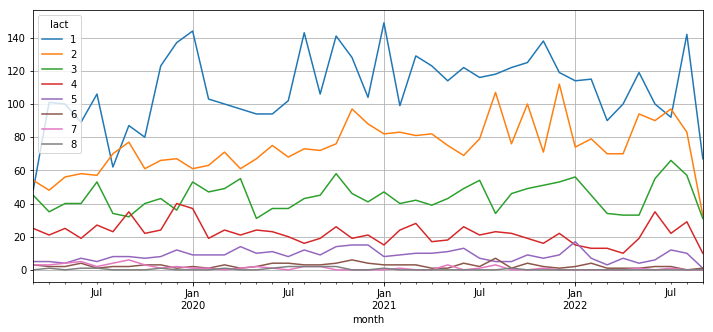

In [1375]:
data.query('lact >0 and event ==14').pivot_table(
    index = "month",  
    columns = 'lact',
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(12, 5)) #отелы

In [1376]:
fresh_and_mastit_1_lact =data.query('lact == 1 and event ==14 and month > "2020-08-01"').pivot_table(
    index = "month",  
    columns = 'lact',
    values = 'cow_id', 
    aggfunc = 'nunique').merge(
data_mastitis.query('lact == 1 and dim < 30 and month > "2020-08-01"').pivot_table(
    index='month',
    columns = 'lact',
    values = 'cow_id', 
    aggfunc={'nunique'}).fillna(0), on ='month') #отелы заболели маститом в 1 лактации

In [1377]:
fresh_and_mastit_1_lact.columns = ['fresh', 'mastit_30dim']

In [1378]:
fresh_and_mastit_1_lact['persent_mastitis'] = fresh_and_mastit_1_lact['mastit_30dim']/fresh_and_mastit_1_lact['fresh']

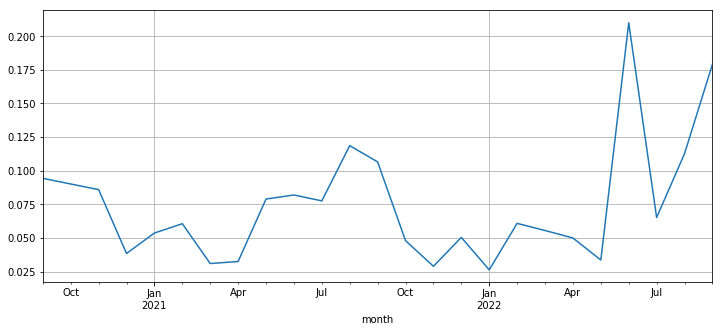

In [1379]:
fresh_and_mastit_1_lact['persent_mastitis'].plot(grid=True, figsize=(12, 5))

Отелилось больше первотелок, но и % заболевших у отелившихся был выше

In [1380]:
pivot_part = data_mastitis.pivot_table(
    index='month', 
    values = ['FR','FL', 'BR', 'BL'], 
    aggfunc='sum').fillna(0) 
##маститы по долям

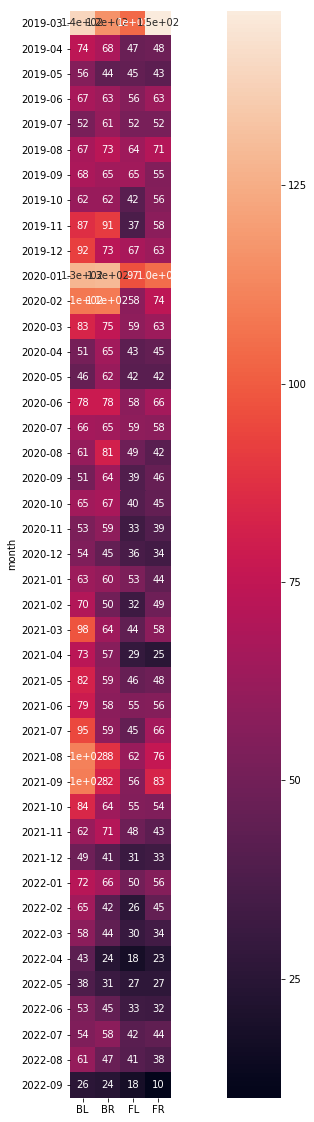

In [1381]:
plt.figure(figsize = (20,20))
sns.heatmap(pivot_part, annot = True, square = True) 
## чаще всего страдает задняя левая доля - субъективно кажется, что задние доли страдают чаще передних. Вопрос чистоты

Салфетки

# Воспроизводство

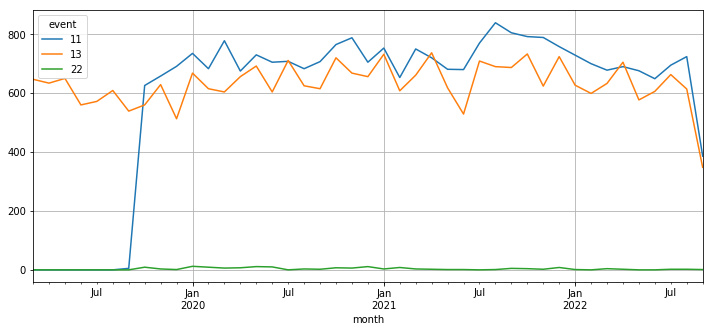

In [1382]:
data.query('event ==11 or event ==22 or event ==13').pivot_table(
    index = "month",  
    columns = 'event',
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(12, 5)) ## на схему, со схемы осеменения

До сентября 19 года не использовали схем синхронизации или не вносили об этом данных (что вероятнее всего, потому что процент осемененных не изменился)

In [1383]:
rep_data = data.query('event ==11 or event ==22 or event ==13 or (event ==23 and day_of_preg < 100) or event ==24').pivot_table(
    index = "month",  
    columns = 'event',
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).reset_index()

In [1384]:
rep_data.columns = ['month', 'schem', 'bred', 'out_of_schem', 'preg', 'preg_before']

In [1385]:
rep_data['preg_vs_bred'] =100 *(rep_data['preg'])/rep_data['bred']

In [1386]:
rep_data['preg_vs_bred'] = rep_data['preg_vs_bred'].round(0)

In [1387]:
rep_data = rep_data.set_index('month')

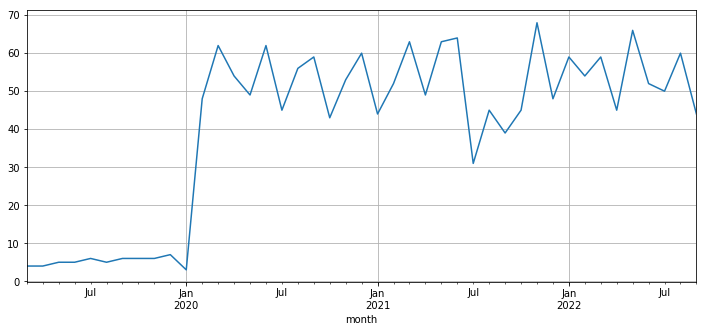

In [1388]:
rep_data['preg_vs_bred'].plot(grid=True, figsize=(12, 5)) #стельные к осемененным

Есть единичное падение в % осемененных в июле 2021года и рост с авуста по ноябрь 2021.


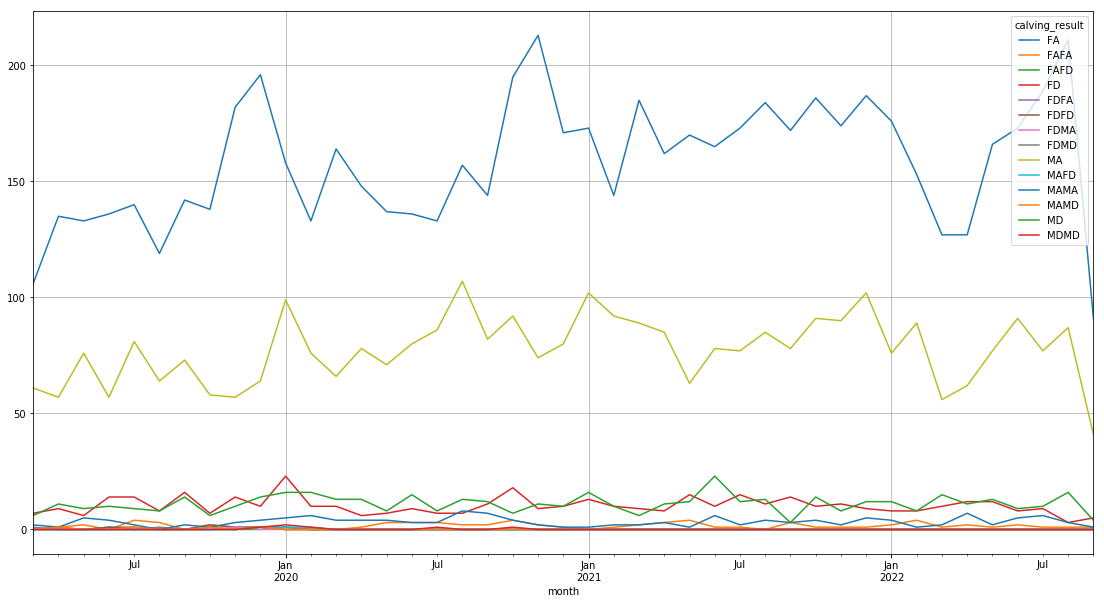

In [1390]:
data.query('event ==14').pivot_table(
    index = "month",  
    columns = 'calving_result',
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(19, 10)) ##рожденные телята

Используют сексированное семя - девочек рождается больше

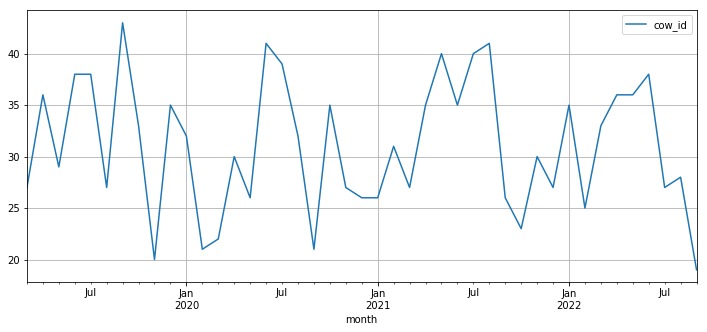

In [1391]:
data.query('event ==1').pivot_table(
    index = "month",  
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(12, 5)) ## аборты

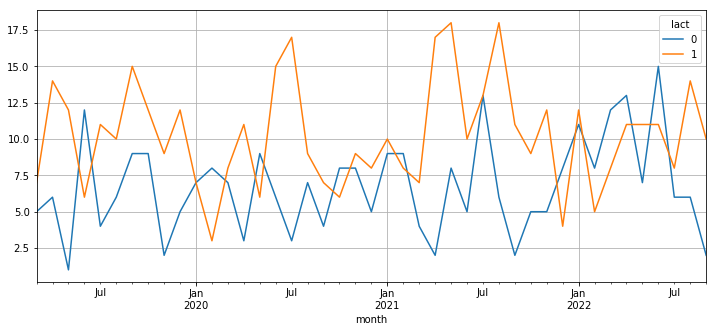

In [1392]:
data.query('event ==1 and lact <2').pivot_table(
    index = "month",  
    columns = 'lact',
    values = 'cow_id', 
    aggfunc = 'nunique').fillna(0).plot(grid=True, figsize=(12, 5)) ## аборты

In [1487]:
data.query('event ==1 and month > "2022-01-01"').pivot_table(
    index = "month",  
    columns = 'lact',
    values = 'cow_id', 
    aggfunc = 'nunique', margins = True).fillna(0)

lact,0,1,2,3,4,5,All
month,,,,,,,
2022-02,8.0,5.0,9.0,1.0,1.0,1.0,25
2022-03,12.0,8.0,9.0,2.0,2.0,0.0,33
2022-04,13.0,11.0,8.0,4.0,0.0,0.0,36
2022-05,7.0,11.0,12.0,4.0,2.0,0.0,36
2022-06,15.0,11.0,6.0,4.0,1.0,1.0,38
2022-07,6.0,8.0,10.0,3.0,0.0,0.0,27
2022-08,6.0,14.0,6.0,1.0,1.0,0.0,28
2022-09,2.0,10.0,5.0,2.0,0.0,0.0,19
All,66.0,72.0,61.0,20.0,7.0,2.0,228


Всплески абортов у первотелок нуждаются в доисследовании. Количество абортов держалось выше 30 в период с апреля 2022 по июнь 2022. В июле 2022 был всплеск мастита у новотельных коров. 

In [1396]:
data_mastitis_and_health['in_mastitis_status'] = 0

In [1397]:
list_of_cow_id=data_mastitis_and_health['cow_id'].unique()

In [1398]:
data_count_health=data_mastitis_and_health.query('event == 7').sort_values(
    by = ['cow_id', 'event_date']).reset_index(inplace = False)

In [1399]:
data_count_health = data_count_health[['unique_event_id', 'cow_id', 'event', 'event_date', 'comment',
       'in_mastitis_status']]

In [1400]:
for i in list_of_cow_id:
    data_count_health.loc[data_count_health['cow_id'] == i,'in_mastitis_status'] =np.arange(len(data_count_health.loc[data_count_health['cow_id'] == i]))+1

In [1401]:
data_count_health

,unique_event_id,cow_id,event,event_date,comment,in_mastitis_status
0,9,321,7,2019-04-01,МАСТИТ,1
1,574640,1010,7,2022-08-13,МАСТИТ,1
2,569510,1018,7,2022-07-18,МАСТИТ,1
3,477293,1027,7,2021-12-27,МАСТИТ,1
4,485268,1078,7,2022-01-17,МАСТИТ,1
...,...,...,...,...,...,...
4262,544058,912217,7,2022-05-24,МАСТИТ,2
4263,497546,912226,7,2022-02-16,МАСТИТ,1
4264,510036,912227,7,2022-03-18,МАСТИТ,1
4265,509015,912232,7,2022-03-15,МАСТИТ,1


# Исследование сухостоя

In [1407]:
data_for_dry_cow = data[['cow_id','lact','calving_result', 'calving_score', 'event', 'event_date','comment']]

In [1408]:
data_for_dry_cow = data_for_dry_cow.query('event == 26')

In [1409]:
data_for_dry_cow.head()

,cow_id,lact,calving_result,calving_score,event,event_date,comment
19,353,7,FA,1,26,2019-04-04,CEBA
98,1595,6,FA,1,26,2019-03-14,CEBA
134,2051,5,MA,1,26,2019-04-18,-
201,2462,5,FA,3,26,2019-03-24,-
214,2542,6,MA,1,26,2019-04-18,-


In [1410]:
data_for_dry_cow.columns = ['cow_id', 'lact', 'prev_calving_result', 'prev_calving_score', 'dry_event',
       'prev_dry_event_date', 'dry_event_comment']

In [1411]:
data_for_dry_cow['lact'] = data_for_dry_cow['lact'] +1
## после отела лактация увеличится на 1 (чтобы правильно соединить таблицы)

In [1412]:
dry_lact_ind = data_for_dry_cow[['cow_id','lact']] 

In [1414]:
dry_lact_ind = dry_lact_ind.drop_duplicates() ## уникальна комбинация 

In [1415]:
len(dry_lact_ind)

6905

In [1416]:
data_for_dry_cow['60days_period'] = data_for_dry_cow['prev_dry_event_date'] +pd.Timedelta(60, "d") 
# 60 дней после события 

In [1417]:
data_for_dry_cow['90days_period'] = data_for_dry_cow['prev_dry_event_date'] +pd.Timedelta(90, "d")
# 90 дней после события

In [1418]:
data_after_dry_event = data.merge(data_for_dry_cow, on =['cow_id', 'lact'])

In [1419]:
data_after_dry_event = data_after_dry_event.loc[data_after_dry_event['event_date'] >= data_after_dry_event['60days_period']]

In [1420]:
data_after_dry_event = data_after_dry_event.loc[data_after_dry_event['event_date'] <= data_after_dry_event['90days_period']]

In [1421]:
data_after_dry_event ##обрезанный датасет в интересующие нас 30 дней после отела

,cow_id,cow_ear_num,sex,lact,calving_result,calving_score,date_of_birth,dryday_prev_period,day_of_preg,pen,...,days_from_birth,month,is_ill,prev_calving_result,prev_calving_score,dry_event,prev_dry_event_date,dry_event_comment,60days_period,90days_period
12,209078,209078,F,5,MD,1,2012-09-07,5,206,6,...,2450,2019-05,0,MA,1,26,2019-03-21,CEBA,2019-05-20,2019-06-19
13,209078,209078,F,5,MD,1,2012-09-07,5,206,6,...,2472,2019-06,0,MA,1,26,2019-03-21,CEBA,2019-05-20,2019-06-19
48,403138,403138,F,4,MD,1,2014-03-17,1,0,23,...,1880,2019-05,0,MA,1,26,2019-03-07,-,2019-05-06,2019-06-05
49,403138,403138,F,4,MD,1,2014-03-17,1,0,23,...,1884,2019-05,0,MA,1,26,2019-03-07,-,2019-05-06,2019-06-05
50,403138,403138,F,4,MD,1,2014-03-17,1,0,23,...,1887,2019-05,0,MA,1,26,2019-03-07,-,2019-05-06,2019-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159257,912259,912259,F,2,FAFA,1,2019-12-30,51,0,21,...,980,2022-09,0,FA,1,26,2022-07-07,CEBA,2022-09-05,2022-10-05
159258,912259,912259,F,2,FAFA,1,2019-12-30,51,0,2,...,980,2022-09,0,FA,1,26,2022-07-07,CEBA,2022-09-05,2022-10-05
159259,912263,912263,F,2,FA,1,2019-12-31,63,0,18,...,982,2022-09,0,FA,1,26,2022-07-07,CEBA,2022-09-05,2022-10-05
159260,912263,912263,F,2,FA,1,2019-12-31,63,0,44,...,982,2022-09,1,FA,1,26,2022-07-07,CEBA,2022-09-05,2022-10-05


In [1422]:
illness = ['АБОРТ','БОЛЕЗНЬ', 'КЕТОЗ', 'МАСТИТ', 'МЕТРИТ',
           'ПАРЕЗ', 'ПОСЛЕД','ХРОМОТА', 'ABORT', 'ILLMISC',
           'KETOS', 'LAME', 'MAST', 'METR', 'RP']

In [1423]:
illness_num = [1, 2, 8, 9, 10, 15, 16, 18, 19, 27]

In [1424]:
data_illness_after_dry = data_after_dry_event.query('event in @illness_num')

In [1425]:
data_illness_after_dry['event'].value_counts()

10    2767
27    1366
19     889
2      832
18     770
9      744
8      740
16     125
15      74
Name: event, dtype: int64

In [1426]:
data_illness_after_dry['dry_event_comment'] = data_illness_after_dry['dry_event_comment'].fillna('-')
data_illness_after_dry['dry_event_comment'] = data_illness_after_dry['dry_event_comment'].replace('CEBA', 'СЕВА')
data_illness_after_dry['dry_event_comment'] = data_illness_after_dry['dry_event_comment'].replace('СEBA', 'СЕВА')
data_illness_after_dry['dry_event_comment'] = data_illness_after_dry['dry_event_comment'].replace('0', '-')

In [1428]:
data_dry_SEVA = data_illness_after_dry.query('dry_event_comment == "СЕВА"').drop(columns = ['dry_event_comment'])
data_dry_auto = data_illness_after_dry.query('dry_event_comment != "СЕВА"').drop(columns = ['dry_event_comment'])
   

In [1429]:
data_dry_SEVA = data_dry_SEVA[['cow_id', 'lact', 'calving_result',
       'calving_score', 'dryday_prev_period', 'day_of_preg',
       'event', 'dim', 'event_date', 'comment','prev_calving_result', 'prev_calving_score',
       'dry_event', 'prev_dry_event_date']]

In [1430]:
data_illness_after_dry.pivot_table(
    index = 'event', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='count').fillna(0)

dry_event_comment,-,AZIT,СЕВА
event,,,
2,286.0,0.0,546.0
8,204.0,0.0,536.0
9,189.0,0.0,555.0
10,615.0,11.0,2141.0
15,27.0,0.0,47.0
16,40.0,0.0,85.0
18,214.0,3.0,553.0
19,323.0,1.0,565.0
27,358.0,0.0,1008.0


In [1431]:
data_illness_after_dry['cow_id_and_lact'] = data_illness_after_dry['cow_id'].astype('str') + " " + data_illness_after_dry['lact'].astype('str')

In [1433]:
data_illness_after_dry.pivot_table(
    index = 'event', 
    columns = 'dry_event_comment', 
    values = 'cow_id_and_lact', 
    aggfunc ='nunique').fillna(0) ##считаем корову в разных лактациях - разными коровами - весь период

dry_event_comment,-,AZIT,СЕВА
event,,,
2,209.0,0.0,434.0
8,199.0,0.0,524.0
9,120.0,0.0,360.0
10,557.0,11.0,1997.0
15,27.0,0.0,47.0
16,40.0,0.0,85.0
18,214.0,3.0,552.0
19,323.0,1.0,565.0
27,188.0,0.0,539.0


In [1467]:
data_illness_after_dry.query('month > "2021-01-01"').pivot_table(
    index = 'event', 
    columns = 'dry_event_comment', 
    values = 'cow_id_and_lact', 
    aggfunc ='nunique').fillna(0) ##считаем корову в разных лактациях - разными коровами с января 2021

dry_event_comment,-,AZIT,СЕВА
event,,,
2,99.0,0.0,214.0
8,134.0,0.0,267.0
9,61.0,0.0,183.0
10,365.0,11.0,1242.0
15,7.0,0.0,18.0
16,16.0,0.0,47.0
18,134.0,3.0,359.0
19,179.0,1.0,326.0
27,67.0,0.0,220.0


In [1434]:
data_illness_after_dry.pivot_table(
    columns = 'dry_event_comment', 
    values = 'cow_id_and_lact', 
    aggfunc ='nunique').fillna(0) ## весь период 

dry_event_comment,-,AZIT,СЕВА
cow_id_and_lact,1093,13,3273


In [1488]:
data_illness_after_dry.query('month > "2021-01-01"').pivot_table(
    columns = 'dry_event_comment', 
    values = 'cow_id_and_lact', 
    aggfunc ='nunique').fillna(0) ## c января 2021 года

dry_event_comment,-,AZIT,СЕВА
cow_id_and_lact,595,13,1835


In [1435]:
mastit_after_auto = 218/1093

In [1436]:
mastit_after_SEVA = 360/3273

In [1470]:
## За весь период по маститу

alpha = .05 # критический уровень статистической значимости

successes = np.array([218, 360])
trials = np.array([1093, 3273])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  4.1522341120980855e-14
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [1469]:
## С января 2021г по маститу

alpha = .05 # критический уровень статистической значимости

successes = np.array([61, 183])
trials = np.array([595, 1835])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.8438132527511577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Коровы, которых запускали препаратом СЕВА, с меньшей вероятностью будут болеть маститом, чем если запускать корову без препарата. (11% заболевших против 16.3% при запуске без фармы)

In [1439]:
metrit_auto = 569/1093 
print(metrit_auto)

0.5205855443732845


In [1440]:
metrit_CEVA = 1997/3273 
print(metrit_CEVA)

0.6101435991445158


In [1471]:
## За весь период по метриту

alpha = .05 # критический уровень статистической значимости

successes = np.array([569, 1093])
trials = np.array([1093, 3273])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [1472]:
## С 2021 года по метриту
alpha = .05 # критический уровень статистической значимости

successes = np.array([365, 1242])
trials = np.array([595, 1835])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.004520549065745394
Отвергаем нулевую гипотезу: между долями есть значимая разница


Коровы, которых запускали препаратом СЕВА, с большей вероятностью будут болеть метритом, чем если запускать корову без препарата. (61% заболевших против 52% при запуске без фармы). А если брать в анализ данные с января 2021 г то разница будет 61 % без фарма против 68% с СЕВА 

In [1473]:
365/595


0.6134453781512605

In [1474]:
1242/1835

0.6768392370572207

In [1443]:
data_illness_after_dry['month'] = data_illness_after_dry['event_date'].dt.to_period('M')

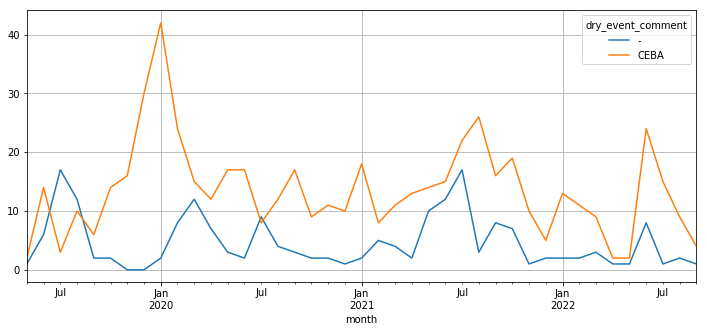

In [1444]:
data_illness_after_dry.query('event == 9').pivot_table(
    index = 'month', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='count').fillna(0).plot(grid=True, figsize=(12, 5)) ##маститы

In [1452]:
mastit_after_dry = data_illness_after_dry.query('event == 9').pivot_table(
    index = 'month', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='count').fillna(0).merge(
    data_illness_after_dry.query('dry_event_comment != "AZIT"').pivot_table(
    index = 'month', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='nunique').fillna(0), on='month', suffixes =('_mastit', '_total'))

In [1459]:
mastit_after_dry.head(5)

dry_event_comment,-_mastit,СЕВА_mastit,-_total,СЕВА_total,ceva_result,auto_result
month,,,,,,
2019-05,1.0,2.0,16,20,10.000000,6.250000
2019-06,6.0,14.0,44,32,43.750000,13.636364
2019-07,17.0,3.0,49,17,17.647059,34.693878
2019-08,12.0,10.0,42,46,21.739130,28.571429
2019-09,2.0,6.0,8,60,10.000000,25.000000


In [1458]:
mastit_after_dry['ceva_result'] = 100*mastit_after_dry['СЕВА_mastit']/mastit_after_dry['СЕВА_total']
mastit_after_dry['auto_result'] = 100*mastit_after_dry['-_mastit']/mastit_after_dry['-_total']

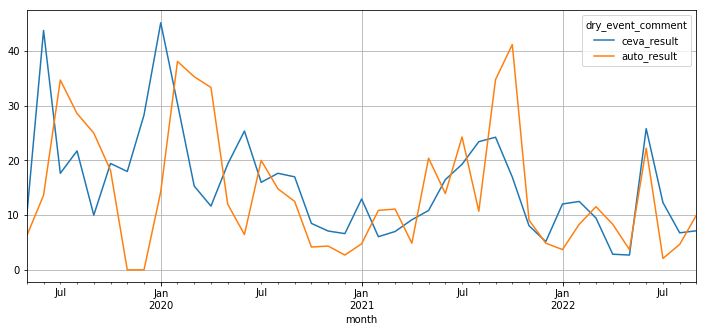

In [1464]:
mastit_after_dry[['ceva_result', 'auto_result']].plot(grid=True, figsize=(12, 5))

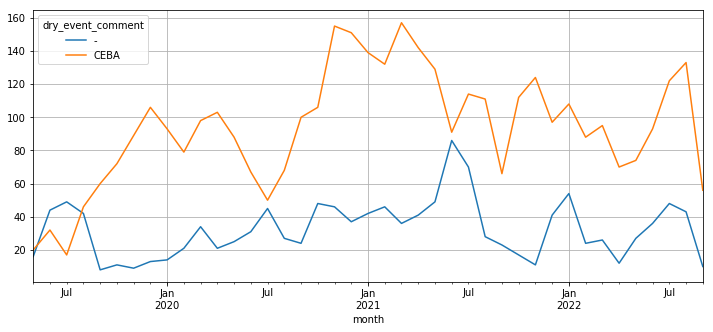

In [1465]:
data_illness_after_dry.query('dry_event_comment != "AZIT"').pivot_table(
    index = 'month', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='nunique').fillna(0).plot(grid=True, figsize=(12, 5))

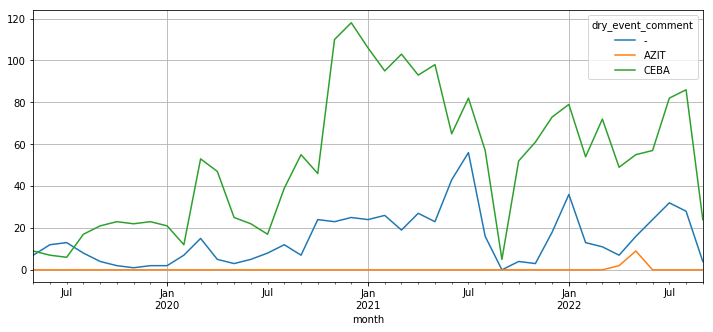

In [860]:
data_illness_after_dry.query('event == 10').pivot_table(
    index = 'month', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='count').fillna(0).plot(grid=True, figsize=(12, 5)) ##метриты

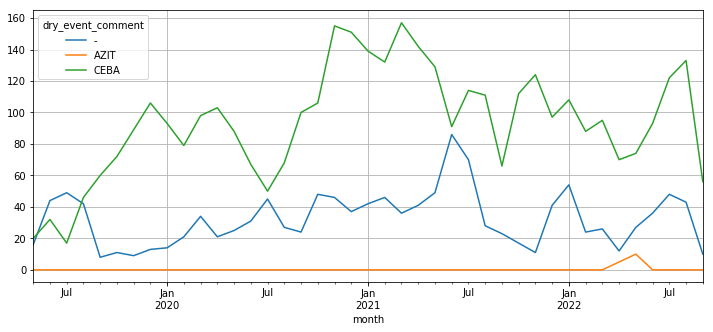

In [863]:
data_illness_after_dry.pivot_table(
    index = 'month', 
    columns = 'dry_event_comment', 
    values = 'cow_id', 
    aggfunc ='nunique').fillna(0).plot(grid=True, figsize=(12, 5)) ##болеющих коров всего

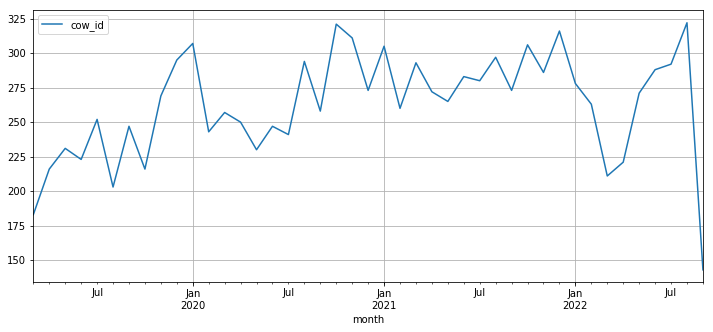

In [871]:
data.query('event == 14').pivot_table(
    index = 'month',  
    values = 'cow_id', 
    aggfunc ='count').fillna(0).plot(grid=True, figsize=(12, 5)) ##новотельные

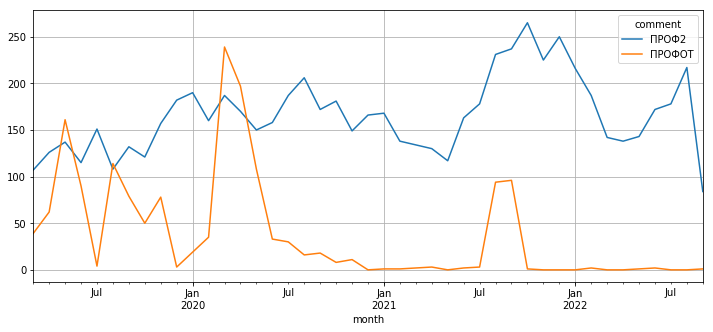

In [870]:
data.query('comment == "ПРОФ2" or comment == "ПРОФОТ" or comment == "ПЭ1" or comment == "ПЭ2" ').pivot_table(
    index = 'month',
    columns = 'comment',
    values = 'cow_id', 
    aggfunc ='count').fillna(0).plot(grid=True, figsize=(12, 5)) ## схемы профилактики

,cow_id,cow_ear_num,sex,lact,calving_result,calving_score,date_of_birth,dryday_prev_period,day_of_preg,pen,prev_pen,event,dim,event_date,comment,days_from_birth,month,is_ill
50,784,887549119,F,8,MD,1,2010-04-27,62,0,43,43,20,0,2019-04-03,ПРОФ2,3263,2019-04,0
68,876,569234430,F,7,FA,1,2010-01-28,57,0,44,18,20,0,2019-04-21,ПРОФ2,3370,2019-04,0
111,1867,2971301867,F,7,FA,1,2011-03-11,66,285,18,18,20,0,2019-04-14,ПРОФ2,2956,2019-04,0
140,2090,3876302090,F,6,MA,1,2010-09-04,58,0,44,44,20,0,2019-03-23,ПРОФ2,3122,2019-03,0
399,52114,533452114,F,6,FA,2,2010-04-19,64,0,23,23,20,414,2019-03-29,ПРОФ2,3266,2019-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592136,912153,912153,F,2,FA,1,2019-12-19,54,0,44,10,20,0,2022-08-02,ПРОФ2,957,2022-08,0
592154,912167,912167,F,2,MA,1,2019-12-21,62,0,44,2,20,0,2022-08-24,ПРОФ2,977,2022-08,0
592174,912180,912180,F,2,FA,1,2019-12-22,58,0,44,21,20,0,2022-08-30,ПРОФ2,982,2022-08,0
592193,912194,912194,F,2,FA,1,2019-12-24,57,0,44,2,20,0,2022-09-02,ПРОФ2,983,2022-09,0


# Кластеры заболевших животных

In [960]:
X = data.query('is_ill == 1 and lact >0').drop(columns = ['cow_ear_num','cow_id','days_from_birth','sex','f_live', 'calving_result','date_of_birth', 'is_ill', 'prev_pen', 'event_date', 'month','comment'])

In [961]:
X

,lact,calving_score,dryday_prev_period,day_of_preg,pen,event,dim
5,6,3,62,291,18,9,213
6,6,3,62,291,18,9,215
8,6,3,62,291,18,9,221
16,6,3,62,291,18,27,252
35,6,1,63,0,23,2,138
...,...,...,...,...,...,...,...
592239,2,1,60,0,2,10,17
592244,2,1,52,0,21,10,0
592249,2,1,52,0,2,10,17
592289,2,1,51,0,21,18,6


In [962]:
scaler = StandardScaler()

In [1013]:
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)

In [1014]:
X_sc = scaler.fit_transform(X_test)

C:\Users\chysh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\chysh\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [1015]:
X_test

,lact,calving_score,dryday_prev_period,day_of_preg,pen,event,dim
46119,3,1,60,277,18,27,334
356344,3,1,63,0,2,18,6
955,4,1,58,0,41,1,223
566870,3,1,57,0,44,16,0
301428,2,1,60,0,10,10,0
...,...,...,...,...,...,...,...
85753,2,3,50,271,18,27,366
90974,1,1,0,188,7,27,63
104354,2,2,59,0,5,1,309
427383,2,1,61,0,4,18,7


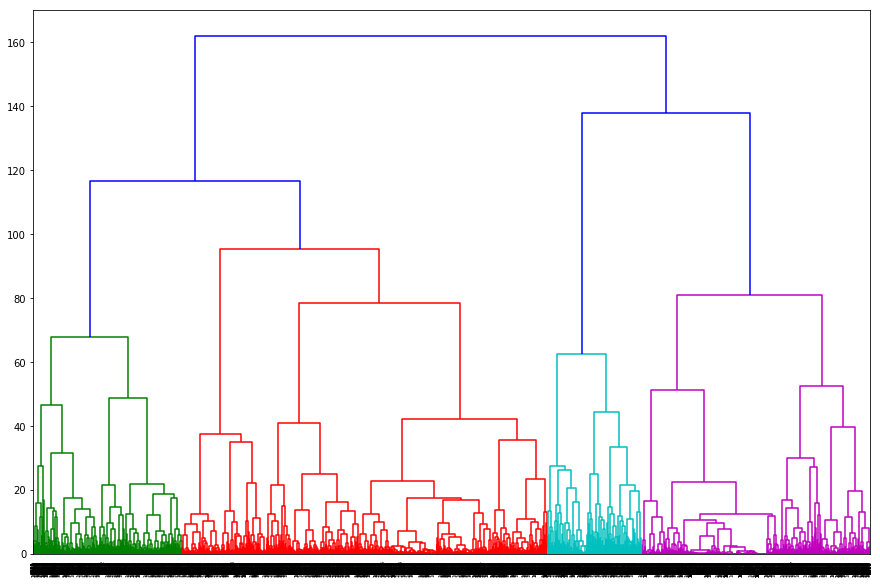

In [1016]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

In [1033]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)

In [1034]:
X_test['cluster_km'] = labels

C:\Users\chysh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1035]:
X_test.groupby('cluster_km').median()

,lact,calving_score,dryday_prev_period,day_of_preg,pen,event,dim
cluster_km,,,,,,,
0,2,1,58,238,18,27,257
1,1,1,0,0,8,10,18
2,3,1,60,0,43,9,27
3,3,1,61,0,5,10,31
4,2,3,51,0,9,10,108


In [1036]:
X_test.groupby('cluster_km').mean()

,lact,calving_score,dryday_prev_period,day_of_preg,pen,event,dim
cluster_km,,,,,,,
0,2.408492,1.042460,46.037579,219.592484,19.758907,19.130307,266.172279
1,1.007217,1.042903,0.111468,35.335605,12.337610,11.534082,67.993986
2,3.271028,1.029475,60.255931,17.762042,42.790798,11.890007,76.807333
3,2.960100,1.026046,60.763369,25.142976,6.825713,13.593793,74.415073
4,2.203579,2.968680,33.070470,75.693512,17.138702,15.785235,137.467562


In [1037]:
numeric_list=['dryday_prev_period', 'day_of_preg', 'dim']

In [1038]:
categorical_list =['lact', 'calving_score', 'pen','event']

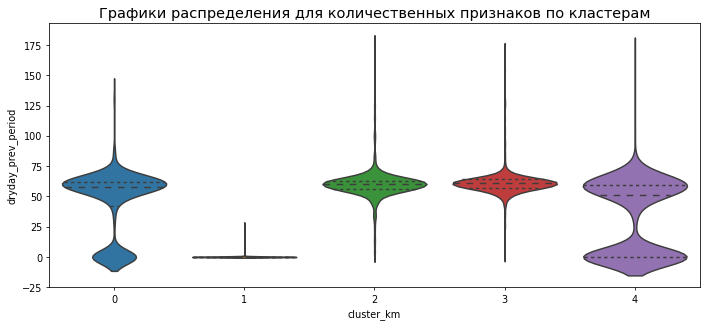

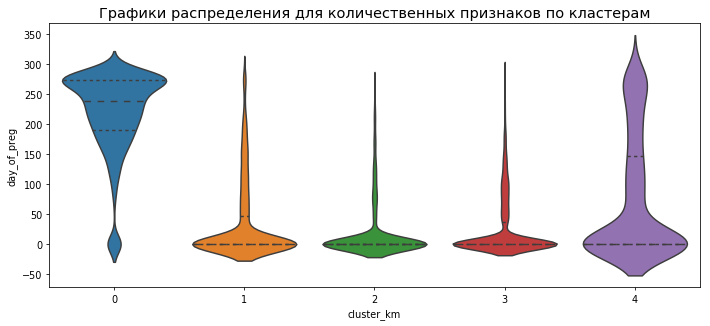

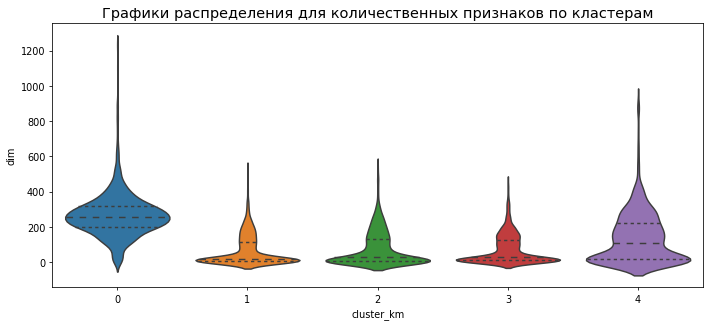

In [1039]:
for i in numeric_list:
    plt.figure(figsize=(12,5), dpi= 70)
    sns.violinplot(x= 'cluster_km', y= i, data=X_test, scale='width', inner='quartile')
    plt.title('Графики распределения для количественных признаков по кластерам', fontsize=15)
    plt.show()

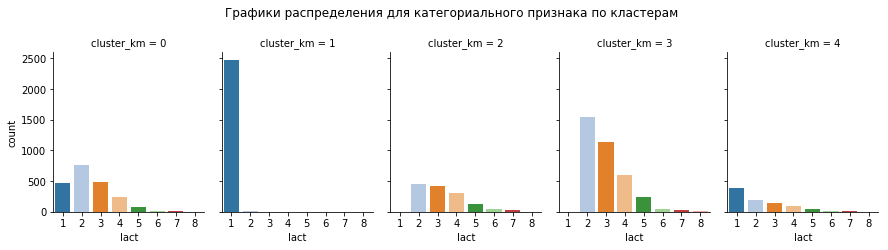

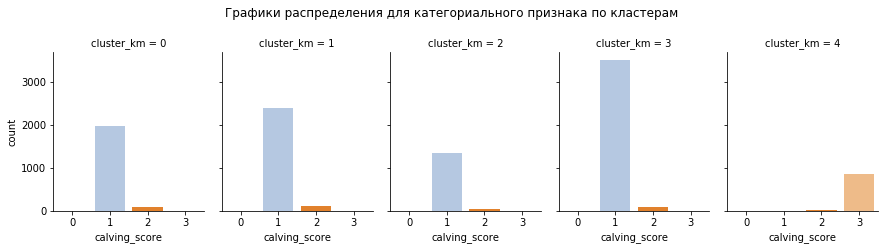

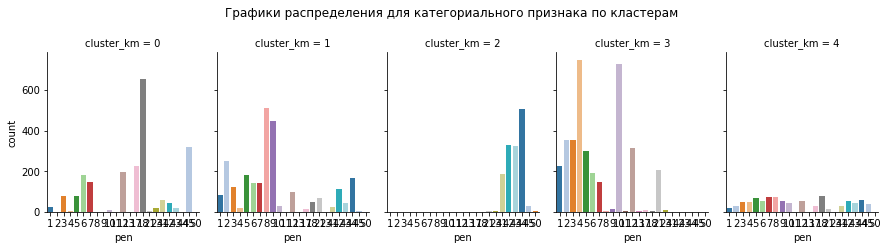

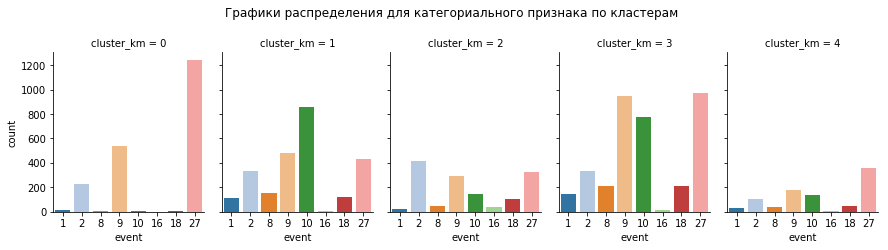

In [1040]:
for i in categorical_list:

    g = sns.catplot(i, col="cluster_km", col_wrap=5,
                    data=X_test,
                    kind="count", height=3.5, aspect=.7, 
                    palette='tab20')
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle('Графики распределения для категориального признака по кластерам')
    plt.show()

Дендрограмма помогает предположить 5 кластеров среди заболевших животных - признаки этих кластеров помогут определить зоны риска. Кластер группы 43 очевиден - животные карантина.Затем кластер первотелок с метритом, маститом и хромотой, а так же высокой по сравнению с остальными кластерами частотой возникновения кетозов, кластер коров всех лактаций после тяжелого отела с метритом, маститом и хромотой, с днями доения зачастую выше 30 - средние дни доения по этому кластеру 108. А так же коорвы глуокого сухостоя с хромотой. 